# Active Learning for MLFF. 


This is a notebook to test active learning workflow for different kinds of MLFF. 

## Import Libraries

In [4]:
from ase.io import read,write
import os
import argparse
from chgnet.model.dynamics import CHGNetCalculator
from chgnet.model import CHGNet
import contextlib
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/mnt/e/Documents/GitHub/MLFF_training/Training')
import ase_active_learning as al 
from ase.visualize import view
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, clear_output
from ase.visualize import view
import matplotlib.pyplot as plt
import importlib
import pickle

In [16]:
importlib.reload(al)

<module 'ase_active_learning' from '/storage/nas_scr/im0225/scripts/MLFF_training/Training/ase_active_learning.py'>

## Get configuration space

From a file that is able to be read by ASE , we are able to import structures. 

In [6]:
Z_of_type = {1:9,2:57,3:3,4:8,5:40,}
configurations = al.get_configuration_space('/storage/nas_scr/im0225/LLZO/mace/dic8_mace_test.xyz')
len(configurations)

13696

In [7]:
view(configurations[-1], viewer='x3d')

## Load MLFF models

Loads all models from a the target directory so that we can test their deviation. Preferably choose more than 3. 

We are loading  models of our reduced data. We are going to use CPU for this test. 

In [17]:
device = 'cuda'
models = al.load_models('/storage/nas_scr/im0225/LLZO/mace/MACE_models/al_test',calculator='mace',device=device)
len(models)

Successfully loaded 3 models.


3

## Obtain the standard deviation after calculator energy,forces,and stress using our 3 MLFF models. 

This step will take the longest as it's calculating the energies of the configuration space X how many models you have. This step is incredibly sped-up with GPU's. 

In [20]:
all_configurations = al.calculate_properties(configurations,models=models,device=device,calculator='mace')
std_dev,rmsd,energy,forces = al.calculate_std_dev(all_configurations,cache_file=pickle)

NameError: name 'MACE' is not defined

In [141]:
#Define pickle file if you have previously run a calculation:
pickle = 'data.pkl'

In [162]:
# Check if the pickle file exists
if os.path.exists('data.pkl'):
    print("Loading data from pickle file...")
    with open('./data.pkl', 'rb') as f:
        data = pickle.load(f)
else:
    print("Pickle file not found. Calculating properties...")
    # Replace `al.calculate_energies_and_std` with the actual function you use
    all_configurations = al.calculate_properties(configurations,models=models,device=device)
    std_dev,rmsd,energy,forces = al.calculate_std_dev(all_configurations,cache_file=pickle)

Pickle file not found. Calculating properties...
CHGNet will run on cuda
CHGNet will run on cuda
CHGNet will run on cuda


Processing Energies and Forces: 100%|██████████| 1440/1440 [01:10<00:00, 20.34it/s]

Error processing cache file: expected 'f' to be string, path, or a file-like object with a 'write' attribute


In [ ]:
for idx, std in enumerate(std_dev):
    if std > 20:
        print(f"Position {idx} has a std > 50: {std}")



Position 413 has a std > 50: 26.84042035678086
Position 579 has a std > 50: 21.053834703106862
Position 2340 has a std > 50: 88.70384678553121


In [164]:
for idx, std in enumerate(rmsd):
    if std > 5:
        print(f"Position {idx} has a std > 50: {std}")
        print(all_configurations[0][idx].info)



Position 57 has a std > 50: 9.62164306640625
{'filepath': '/home/ignacio/Documents/misc/configuration/frac4_uc/llzo-nvt-heating-1400_filtered.lmp', 'config_index': 1700}
Position 67 has a std > 50: 7.595912933349609
{'filepath': '/home/ignacio/Documents/misc/configuration/frac4_uc/llzo-nvt-heating-1400_filtered.lmp', 'config_index': 2700}
Position 234 has a std > 50: 34.522850036621094
{'filepath': '/home/ignacio/Documents/misc/configuration/frac4_uc/llzo-nvt-heating-1300_filtered.lmp', 'config_index': 3400}


In [135]:
all_configurations[0][413].info

{'filepath': '/home/ignacio/Documents/misc/configuration/frac4_uc/llzo-nvt-heating-1400_filtered.lmp',
 'config_index': 130}

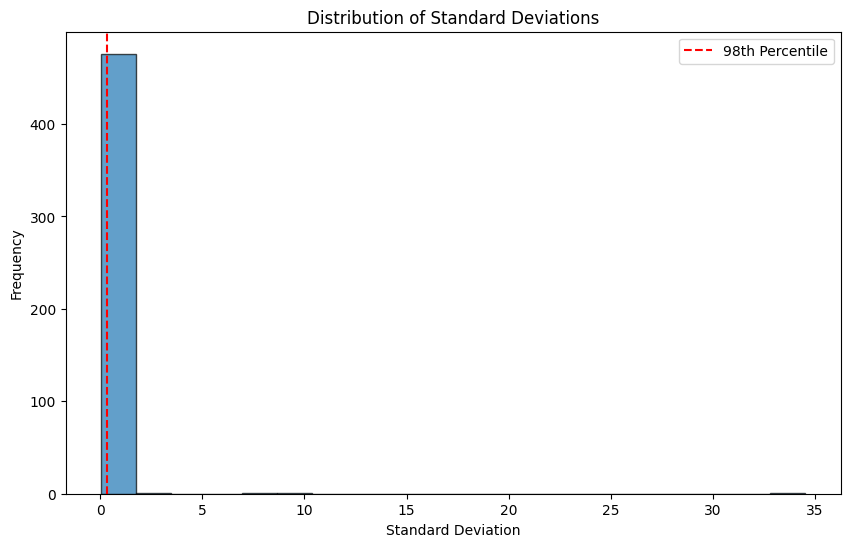

In [146]:
plt.figure(figsize=(10, 6))
plt.hist(rmsd, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.axvline(x=np.percentile(std_dev, 98), color='r', linestyle='--', label='98th Percentile')
plt.legend()